There are two kinds of bacterial growth measurements available to us
- Optical density (OD) that yields the bacterial growth of each pool of 500 strains for a given drug-concentration combination. 

- Sequencing reads which yields the growth of individual strains for each drug-concentration combination. 

In steps 1-3 we merge the OD and sequencing files, and create OD plots for each drug. 

In step 4, we exclude low high drug concentrations where we expect to be uninformative since all strains show a similar behavior (shaded areas in the picture below)

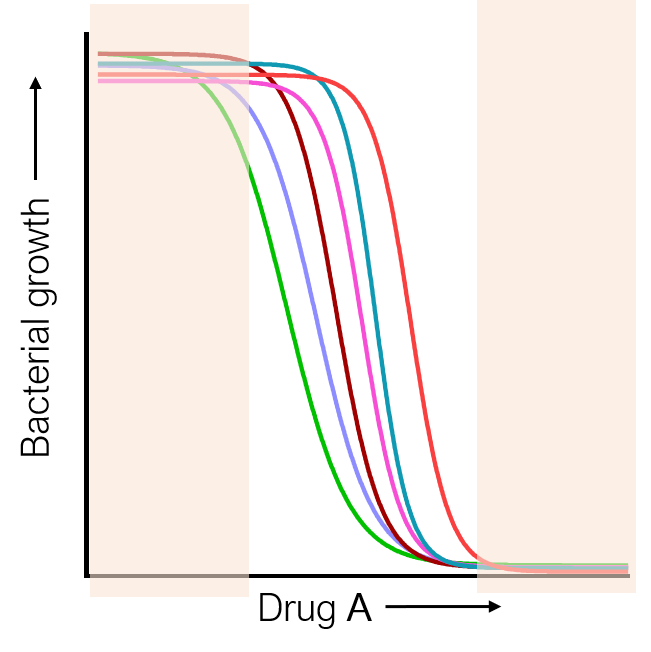

In [4]:
from IPython.display import Image
Image("Sigmoidal_curves/Uninformative.png", width=300)

In step 5 we remove samples which had no signal even though they were not at high drug concentrations - these are likely due to technical errors and we will explore these in detail in the EDA. See an example below: The row highlighted in red has no counts even though there is bacterial growth at that drug concentration

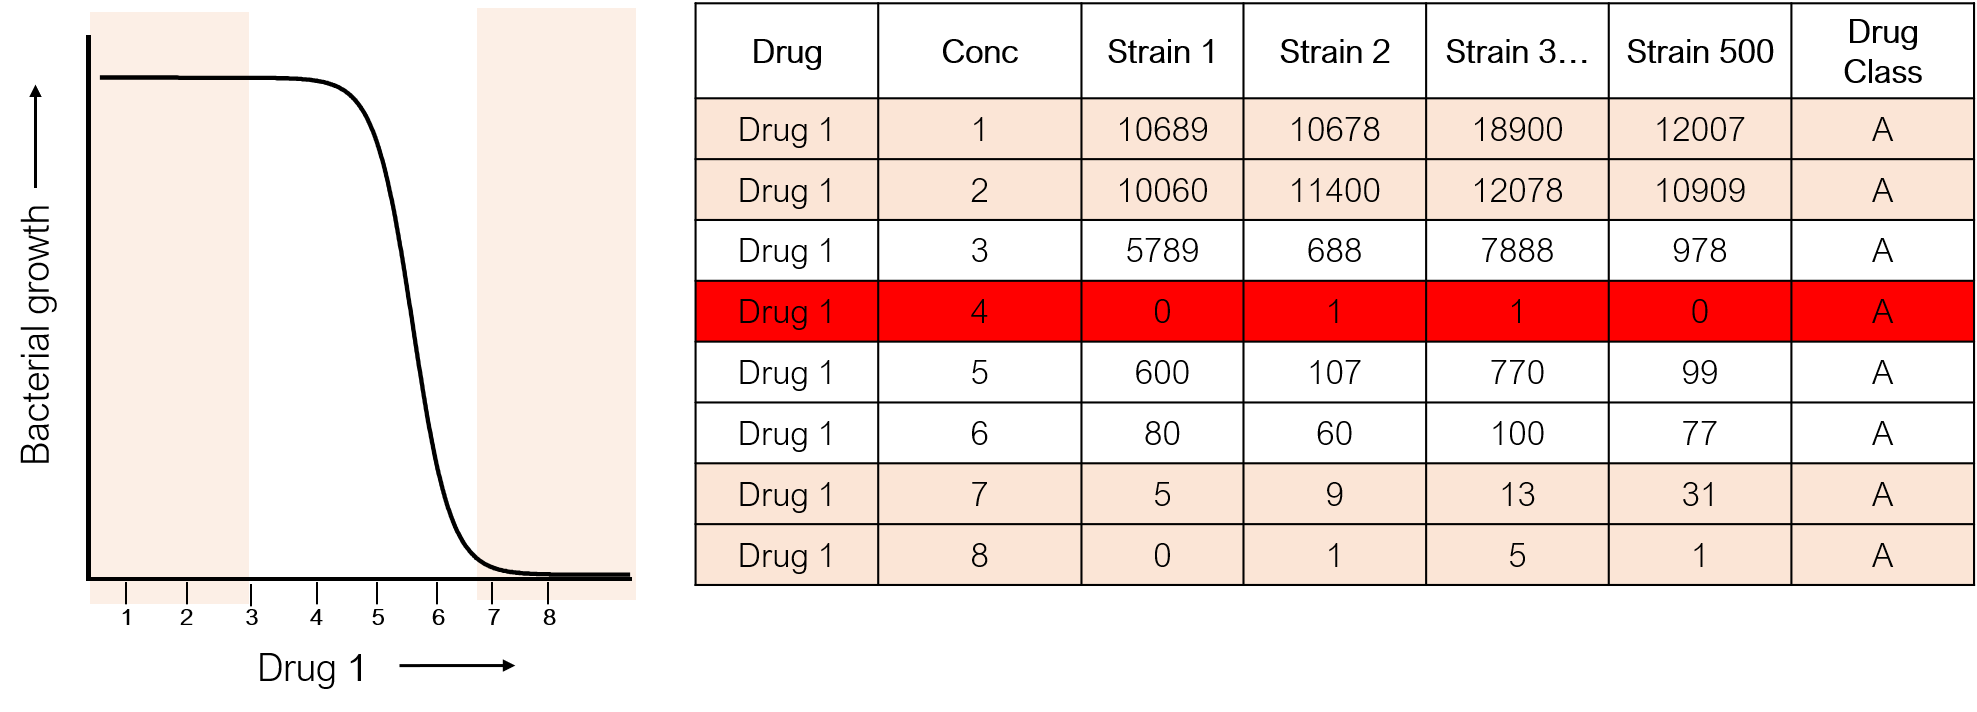

In [7]:
Image("Sigmoidal_curves/badPCR.png", width=800)

PCR is a step in the process of converting cells to sequencing reads that can inject bias into the final counts we obtain.In steps 6-8 we transform and normalize the data to bypass issues related to PCR efficiency. 

Additional details of each step are as under:
1. Merge ODs: OD or optical density is a measure of bacterial growth. In step 4 we will be using ODs to filter our counts files. At this step we take OD measurements and merge them with information on drugs dispensed to enable OD<>drug mapping.  



2. OD plots: For each drug, make a plot showing the dependence of OD on drug concentration.



3. Merge Count Files: This section merges counts files obtained from Illumina sequencing, by summing up reads that come from the same bacterial sample.



4. Select Conditions: High drug concentrations lead to killing of all cells which is uninformative, because we want to look at conditions where the drug kills the most susceptible, but not all, bacteria. Thus, the counts data is filtered based on ODs such that conditions where all bacteria are killed are dropped. 



5. QC/Quality Control: Even though at some drug concentrations there was enough bacterial growth, no reads were obtained. This is likely due to poor PCRs. Flag/remove these rows. Specifically, remove rows in which more than 80% of all strains have counts lower that the threshold of 150. Also, remove strains that showed a mean of <5 counts in the no drug controls



6. Normalize to WT: Since PCRs have varying degrees of efficiency, it is difficult to determine if increased read counts are due to increased bacteria or due to PCR efficiency. To control for this, the counts are normalized to that of the WT strain in these conditions



7. Calculate FC: For each drug, calculate the ratio of growth with and without drug



8. Clean for ML: For predictive modelling, drop the no drug rows, since they have no signal, and merge the known drug classes to use as model output

## Merge ODs

Given 

1) A raw OD file containing bacterial growth measurements

2) A drugs dispensed file with which drug was dispensed in which well

Combine the two, remove unnecessary columns and ensure backwards compatibility

In [6]:
%reset -f

In [7]:
import pandas as pd
import os
import pathlib
%matplotlib inline

In [8]:
ods = pd.read_excel(pathlib.Path.cwd().joinpath('Raw_data', "181120_HypoIII_Ods_encoded.xlsx"))
ods.head()

,Name,InstrumentInfo,ReadTime,Barcode,ReadMode,ReadType,PlateType,Shake,Calibrate,CarriageSpeed,...,Row,Col,RawData,TemperatureData,WellID3,Name4,reducedVal,Rows,Columns,AdditionalExports
0,drug_0,SpectraMax M2e\nROM v3.0.22 16Feb11,9:52 AM 11/20/2018,NaN,Absorbance,Endpoint,96 Well Standard clrbtm,Off,On,Normal,...,1.0,1.0,0.8393,36.6,NaN,NaN,NaN,8,12,NaN
1,drug_0,SpectraMax M2e\nROM v3.0.22 16Feb11,9:52 AM 11/20/2018,NaN,Absorbance,Endpoint,96 Well Standard clrbtm,Off,On,Normal,...,1.0,2.0,0.8193,36.6,NaN,NaN,NaN,8,12,NaN
2,drug_0,SpectraMax M2e\nROM v3.0.22 16Feb11,9:52 AM 11/20/2018,NaN,Absorbance,Endpoint,96 Well Standard clrbtm,Off,On,Normal,...,1.0,3.0,0.8171,36.6,NaN,NaN,NaN,8,12,NaN
3,drug_0,SpectraMax M2e\nROM v3.0.22 16Feb11,9:52 AM 11/20/2018,NaN,Absorbance,Endpoint,96 Well Standard clrbtm,Off,On,Normal,...,1.0,4.0,0.8081,36.6,NaN,NaN,NaN,8,12,NaN
4,drug_0,SpectraMax M2e\nROM v3.0.22 16Feb11,9:52 AM 11/20/2018,NaN,Absorbance,Endpoint,96 Well Standard clrbtm,Off,On,Normal,...,1.0,5.0,0.8001,36.6,NaN,NaN,NaN,8,12,NaN


In [9]:
#delete useless columns
ods = ods.loc[:,['Name', 'Row', 'Col', 'RawData']]
#remove empty wells. Note that plate configuration is central 48 wells within a 96 well plate
ods.dropna(subset = ['Row', 'Col'], how='any', inplace=True)
ods[['Row', 'Col']]=ods[['Row', 'Col']].astype(int)
ods = ods[(ods['Row']>1) & (ods['Row']<8) & (ods['Col']>2) & (ods['Col']<11)]
ods.rename(columns={'RawData': 'OD'}, inplace=True)
ods.head()

,Name,Row,Col,OD
14,drug_0,2,3,0.8929
15,drug_0,2,4,0.2876
16,drug_0,2,5,0.6768
17,drug_0,2,6,0.2796
18,drug_0,2,7,0.7699


In [10]:
all_drugs_dispensed = pd.read_csv(pathlib.Path.cwd().joinpath('Raw_data', 'HypoIII_all_drugs_encoded.csv'))
all_drugs_dispensed.head()


,Plate,Dispensedwell,Dispensedrow,Dispensedcol,Nonrandomwell,Nonrandomrow,Nonrandomcol,xMIC,Replicate,Short
0,29,B03,2,3,B09,2,9,0.125xMIC,1,drug_0
1,29,B04,2,4,B03,2,3,8xMIC,1,drug_0
2,29,B05,2,5,E06,5,6,1xMIC,1,drug_0
3,29,B06,2,6,F04,6,4,4xMIC,1,drug_0
4,29,B07,2,7,G09,7,9,0.125xMIC,2,drug_0


In [11]:
ods_drugs = pd.merge(ods, all_drugs_dispensed, how='left', left_on=['Name', 'Row', 'Col'], right_on=['Short', 'Dispensedrow', 'Dispensedcol'])
ods_drugs.head()

,Name,Row,Col,OD,Plate,Dispensedwell,Dispensedrow,Dispensedcol,Nonrandomwell,Nonrandomrow,Nonrandomcol,xMIC,Replicate,Short
0,drug_0,2,3,0.8929,29,B03,2,3,B09,2,9,0.125xMIC,1,drug_0
1,drug_0,2,4,0.2876,29,B04,2,4,B03,2,3,8xMIC,1,drug_0
2,drug_0,2,5,0.6768,29,B05,2,5,E06,5,6,1xMIC,1,drug_0
3,drug_0,2,6,0.2796,29,B06,2,6,F04,6,4,4xMIC,1,drug_0
4,drug_0,2,7,0.7699,29,B07,2,7,G09,7,9,0.125xMIC,2,drug_0


In [12]:
#confirm merge worked without errors
assert(ods_drugs.Name == ods_drugs.Short).all()
assert ods.shape[0] == all_drugs_dispensed.shape[0] == ods_drugs.shape[0]

CHANGE EXPT NAME!

In [13]:
#insert new columns and delete unnecessary ones
ods_drugs['Exp'] = 'HypoIII'
ods_drugs = ods_drugs[['Exp','Short', 'xMIC', 'Replicate', 'OD']]
ods_drugs.head()

,Exp,Short,xMIC,Replicate,OD
0,HypoIII,drug_0,0.125xMIC,1,0.8929
1,HypoIII,drug_0,8xMIC,1,0.2876
2,HypoIII,drug_0,1xMIC,1,0.6768
3,HypoIII,drug_0,4xMIC,1,0.2796
4,HypoIII,drug_0,0.125xMIC,2,0.7699


In [14]:
#Pivot. Since making pivot table, ensure no duplicates to prevent aggregation function from kicking in
assert ods_drugs.duplicated(subset=['Exp', 'Short', 'xMIC', 'Replicate']).any()==False
ods_drugs_pivoted = ods_drugs.pivot_table(index=['Exp', 'Short', 'xMIC'], columns='Replicate', values='OD').reset_index().rename_axis(None, axis=1)
ods_drugs_pivoted.head()

,Exp,Short,xMIC,1,2,3,4,5,6
0,HypoIII,drug_0,0.000xMIC,0.8485,0.8836,1.0600,0.9194,0.9105,1.0767
1,HypoIII,drug_0,0.125xMIC,0.8929,0.7699,0.8256,0.9274,0.9139,0.9250
2,HypoIII,drug_0,0.25xMIC,0.8841,0.9352,0.9917,0.9324,1.0334,0.9380
3,HypoIII,drug_0,0.5xMIC,0.8940,0.9431,0.8165,0.9041,0.9121,0.8799
4,HypoIII,drug_0,1xMIC,0.6768,0.8807,0.8459,0.9099,0.8927,0.8619


In [15]:
#For backwards compatibililty, rename columns and sort
ods_drugs_pivoted.rename(columns={'Short': 'Drug', 'xMIC':'Conc'}, inplace=True)
#rename columns as R1,R2... etc
number_cols=ods_drugs_pivoted.filter(regex='\d').columns
ods_drugs_pivoted.rename(columns={x:str('R')+str(x) for x in number_cols},inplace=True)
ods_drugs_pivoted.sort_values(by=['Drug', 'Conc'], ascending=[True, False], inplace=True)
ods_drugs_pivoted.head()

,Exp,Drug,Conc,R1,R2,R3,R4,R5,R6
7,HypoIII,drug_0,8xMIC,0.2876,0.5530,0.7734,0.5185,0.5649,0.6715
6,HypoIII,drug_0,4xMIC,0.2796,0.6334,0.4026,0.5253,0.6317,0.6409
5,HypoIII,drug_0,2xMIC,0.6709,0.7067,0.7536,0.7634,0.7847,0.7717
4,HypoIII,drug_0,1xMIC,0.6768,0.8807,0.8459,0.9099,0.8927,0.8619
3,HypoIII,drug_0,0.5xMIC,0.8940,0.9431,0.8165,0.9041,0.9121,0.8799


In [16]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','1-Merge_ODs').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass

In [17]:
ods_drugs_pivoted.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','1-Merge_ODs', 'ODs_drugs.csv'), index=False)

## OD plots

Make plots of ODs versus drugs

In [18]:
%reset -f

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pathlib
%matplotlib inline

Check if OD names match

In [20]:
# Check if OD names match. This ensures that the OD names manually typed into spectrophotometer are standard across experiments
drug_names_correct = pd.read_excel(pathlib.Path.cwd().joinpath('Raw_data','Drug_names_encoded.xlsx'))
drug_names_correct.head()
drug_names_correct = drug_names_correct.astype('str')
drug_names_correct.head()

,Short,Drug
0,drug_0,drug_0
1,drug_1,drug_1
2,drug_2,drug_2
3,drug_3,drug_3
4,drug_4,drug_4


In [21]:
ods_drugs = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','1-Merge_ODs', 'ODs_drugs.csv'))
ods_drugs.head()

,Exp,Drug,Conc,R1,R2,R3,R4,R5,R6
0,HypoIII,drug_0,8xMIC,0.2876,0.5530,0.7734,0.5185,0.5649,0.6715
1,HypoIII,drug_0,4xMIC,0.2796,0.6334,0.4026,0.5253,0.6317,0.6409
2,HypoIII,drug_0,2xMIC,0.6709,0.7067,0.7536,0.7634,0.7847,0.7717
3,HypoIII,drug_0,1xMIC,0.6768,0.8807,0.8459,0.9099,0.8927,0.8619
4,HypoIII,drug_0,0.5xMIC,0.8940,0.9431,0.8165,0.9041,0.9121,0.8799


In [22]:
assert set(ods_drugs.Drug).difference(set(drug_names_correct.Short))==set()

Go ahead with making plots

In [23]:
ods_drugs_m = pd.melt(ods_drugs, id_vars=['Exp', 'Drug', 'Conc'], var_name='Replicate', value_name='OD')
ods_drugs_m.head()

,Exp,Drug,Conc,Replicate,OD
0,HypoIII,drug_0,8xMIC,R1,0.2876
1,HypoIII,drug_0,4xMIC,R1,0.2796
2,HypoIII,drug_0,2xMIC,R1,0.6709
3,HypoIII,drug_0,1xMIC,R1,0.6768
4,HypoIII,drug_0,0.5xMIC,R1,0.8940


In [24]:
#create plot names
ods_drugs_m['Names'] = ods_drugs_m['Exp']+'_'+ods_drugs_m['Drug']
ods_drugs_m = ods_drugs_m.sort_values(by=['Names', 'Conc'])
ods_drugs_m.head()

,Exp,Drug,Conc,Replicate,OD,Names
7,HypoIII,drug_0,0.000xMIC,R1,0.8485,HypoIII_drug_0
703,HypoIII,drug_0,0.000xMIC,R2,0.8836,HypoIII_drug_0
1399,HypoIII,drug_0,0.000xMIC,R3,1.0600,HypoIII_drug_0
2095,HypoIII,drug_0,0.000xMIC,R4,0.9194,HypoIII_drug_0
2791,HypoIII,drug_0,0.000xMIC,R5,0.9105,HypoIII_drug_0


In [25]:
def plot_ODs(group):
    name = group['Names'].values[0]
    p = sns.boxplot(x="Conc", y="OD", data=group, palette='Blues')
    p.set_title(name)
    p.set_xticklabels(p.get_xticklabels(), rotation=20)
    p.set(ylim=(0, 1.5))
    fig = p.get_figure()
    fig.savefig(pathlib.Path.cwd().joinpath('Clean_data_outputs','2-OD_plots', name+'.png'))
    plt.close() 

In [26]:
#Create directories for results
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','2-OD_plots').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass

In [27]:
ods_drugs_m.groupby('Names').apply(plot_ODs)

""


## Merge Count Files

Merge read count files into one by summing up the reads across the same p5-p7 primers.

Caution:This section has backward compatibility issues. Specifically, check the naming of the strains, if they are separated by slash or not. Also check the column titles. The column Name may be called Drug in an earlier experiment

In [28]:
%reset -f

In [29]:
import pandas as pd
import os
import pathlib

In [30]:
def merge_RC(counts_file_path):
    """For a single counts file sum counts for the same p5 and p7. Also rename and remove columns for consistency"""
    counts_file = pd.read_table(counts_file_path, sep='\t', header=0)
    #isolate columns with strains
    strain_cols = list(counts_file.filter(regex='/').columns)
    counts_file = counts_file[['Lane', 'Name', 'xMIC', 'Replicate', 'p5', 'p7'] + strain_cols]
    counts_file_melted = pd.melt(counts_file, id_vars=['Lane', 'Name', 'xMIC', 'Replicate', 'p5', 'p7'], var_name='Strain', value_name='RC')
    
    #for backwards compatibility
    counts_file_melted = counts_file_melted.rename(columns={'Name': 'Drug', 'xMIC':'Conc'})
    #summing
    counts_file_combined = counts_file_melted.groupby(['Drug', 'Conc', 'Replicate', 'Strain', 'p5', 'p7'], as_index=False).sum()
    #replace / with .
    counts_file_combined['Strain'] = counts_file_combined['Strain'].str.replace('/', '.')
    
    return counts_file_combined

In [31]:
dir = pathlib.Path.cwd().joinpath('Raw_data', "Counts_files_encoded")
merged_counts = [merge_RC(x) for x in dir.glob('*.txt')]


In [32]:
#Combine multiple counts files together
combined_counts = pd.concat(x for x in merged_counts)
combined_counts = combined_counts.groupby(['Drug', 'Conc', 'Replicate', 'Strain', 'p5', 'p7'], as_index=False).sum()

In [33]:
combined_counts.head()

,Drug,Conc,Replicate,Strain,p5,p7,RC
0,Input,XXX,1,strain.0,96,1,0
1,Input,XXX,1,strain.1,96,1,0
2,Input,XXX,1,strain.10,96,1,0
3,Input,XXX,1,strain.100,96,1,0
4,Input,XXX,1,strain.101,96,1,0


In [34]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','3-Merge_counts').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass

In [35]:
combined_counts.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','3-Merge_counts', 'Counts_merged.csv'), index=False)
                                                              

## Select Conditions

Based on the OD graphs select relevant datapoints for Clean_data_outputs. Note that highest drug concentrations may be often uninformative since all bacteria will die. Ideally, we want to analyse drug concentratons where the pool is partially growth inhibited. This section selects the three highest xMIC for each drug over the OD cutoff of 0.3

In [36]:
%reset -f

In [37]:
import pandas as pd
import os
import pathlib

In [38]:
ods = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','1-Merge_ODs', 'ODs_drugs.csv'))
ods.head()

,Exp,Drug,Conc,R1,R2,R3,R4,R5,R6
0,HypoIII,drug_0,8xMIC,0.2876,0.5530,0.7734,0.5185,0.5649,0.6715
1,HypoIII,drug_0,4xMIC,0.2796,0.6334,0.4026,0.5253,0.6317,0.6409
2,HypoIII,drug_0,2xMIC,0.6709,0.7067,0.7536,0.7634,0.7847,0.7717
3,HypoIII,drug_0,1xMIC,0.6768,0.8807,0.8459,0.9099,0.8927,0.8619
4,HypoIII,drug_0,0.5xMIC,0.8940,0.9431,0.8165,0.9041,0.9121,0.8799


In [39]:
counts = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','3-Merge_counts', 'Counts_merged.csv'))
counts.head()

,Drug,Conc,Replicate,Strain,p5,p7,RC
0,Input,XXX,1,strain.0,96,1,0
1,Input,XXX,1,strain.1,96,1,0
2,Input,XXX,1,strain.10,96,1,0
3,Input,XXX,1,strain.100,96,1,0
4,Input,XXX,1,strain.101,96,1,0


In [40]:
#remove input
inp = counts[counts['Drug']=='Input']

In [41]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','4-Select_conditions').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass

In [42]:
inp.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','4-Select_conditions', 'input_counts.csv'), index=False)

In [43]:
counts = counts[counts['Drug']!='Input']

In [44]:
#Check if all counts have corresponding ODs
assert set(counts.Drug).issubset(ods.Drug)

In [45]:
#remove zero drug
ods = ods.drop(columns='Exp')
ods['mean'] = ods.filter(regex=('^R\d$')).mean(axis=1)
no_drug_ods = ods[ods.Conc=='0.000xMIC']
drug_ods = ods[ods.Conc!='0.000xMIC']

In [46]:
#restrict to an OD above which cells all cells have not died
sel_ods = drug_ods[drug_ods['mean']>0.3]
sel_ods.head()

,Drug,Conc,R1,R2,R3,R4,R5,R6,mean
0,drug_0,8xMIC,0.2876,0.5530,0.7734,0.5185,0.5649,0.6715,0.561483
1,drug_0,4xMIC,0.2796,0.6334,0.4026,0.5253,0.6317,0.6409,0.518917
2,drug_0,2xMIC,0.6709,0.7067,0.7536,0.7634,0.7847,0.7717,0.741833
3,drug_0,1xMIC,0.6768,0.8807,0.8459,0.9099,0.8927,0.8619,0.844650
4,drug_0,0.5xMIC,0.8940,0.9431,0.8165,0.9041,0.9121,0.8799,0.891617


In [47]:
#Get concentration ranks. 
#This allows us to choose the top three concentrations that have mean OD above the desired cutoff of 0.3
sel_ods['num_conc'] = sel_ods['Conc'].str.replace("xMIC", "").astype('float')
sel_ods['Conc_rank'] = sel_ods.groupby('Drug')['num_conc'].rank()
sel_ods.head(10)

C:\Users\light\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\light\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Drug,Conc,R1,R2,R3,R4,R5,R6,mean,num_conc,Conc_rank
0,drug_0,8xMIC,0.2876,0.5530,0.7734,0.5185,0.5649,0.6715,0.561483,8.000,7.0
1,drug_0,4xMIC,0.2796,0.6334,0.4026,0.5253,0.6317,0.6409,0.518917,4.000,6.0
2,drug_0,2xMIC,0.6709,0.7067,0.7536,0.7634,0.7847,0.7717,0.741833,2.000,5.0
3,drug_0,1xMIC,0.6768,0.8807,0.8459,0.9099,0.8927,0.8619,0.844650,1.000,4.0
4,drug_0,0.5xMIC,0.8940,0.9431,0.8165,0.9041,0.9121,0.8799,0.891617,0.500,3.0
5,drug_0,0.25xMIC,0.8841,0.9352,0.9917,0.9324,1.0334,0.9380,0.952467,0.250,2.0
6,drug_0,0.125xMIC,0.8929,0.7699,0.8256,0.9274,0.9139,0.9250,0.875783,0.125,1.0
11,drug_1,1xMIC,0.2185,0.3727,0.4214,0.4352,0.4461,0.3722,0.377683,1.000,4.0
12,drug_1,0.5xMIC,0.6010,0.6248,0.6415,0.5439,0.5873,0.6548,0.608883,0.500,3.0
13,drug_1,0.25xMIC,0.5250,0.6004,0.7599,0.7117,0.7348,0.6967,0.671417,0.250,2.0


In [48]:
#Get top three ranks
top_ods = pd.DataFrame(sel_ods.groupby(by='Drug')['Conc_rank'].apply(lambda x: x.nlargest(3)))
top_ods.reset_index(level=0, drop=True, inplace=True)
print(top_ods.shape)
top_ods.tail()

(256, 1)


,Conc_rank
683,4.0
684,3.0
689,6.0
690,5.0
691,4.0


In [49]:
#filter top three ranks
sel_ods_top = sel_ods.loc[top_ods.index,:]
sel_ods_top.drop(columns=['num_conc', 'Conc_rank'], inplace=True)

In [50]:
#add no drug back
sel_ods_top = sel_ods_top.append(no_drug_ods).sort_values(by=['Drug', 'Conc'])
sel_ods_top.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','4-Select_conditions', 'ODs_drugs_w_rank_selected.csv'), index=False)
sel_ods_top.head()

,Drug,Conc,R1,R2,R3,R4,R5,R6,mean
7,drug_0,0.000xMIC,0.8485,0.8836,1.0600,0.9194,0.9105,1.0767,0.949783
2,drug_0,2xMIC,0.6709,0.7067,0.7536,0.7634,0.7847,0.7717,0.741833
1,drug_0,4xMIC,0.2796,0.6334,0.4026,0.5253,0.6317,0.6409,0.518917
0,drug_0,8xMIC,0.2876,0.5530,0.7734,0.5185,0.5649,0.6715,0.561483
15,drug_1,0.000xMIC,0.8779,0.8657,0.9229,1.0435,0.9088,0.9837,0.933750


In [51]:
#Drop replicate columns
sel_ods_top.drop(columns=list(sel_ods_top.filter(regex='^R\d$').columns), inplace=True)
sel_ods_top.head()

,Drug,Conc,mean
7,drug_0,0.000xMIC,0.949783
2,drug_0,2xMIC,0.741833
1,drug_0,4xMIC,0.518917
0,drug_0,8xMIC,0.561483
15,drug_1,0.000xMIC,0.933750


In [52]:
counts.head()

,Drug,Conc,Replicate,Strain,p5,p7,RC
2628,drug_0,0.000xMIC,1,strain.0,1,8,2415
2629,drug_0,0.000xMIC,1,strain.1,1,8,1314
2630,drug_0,0.000xMIC,1,strain.10,1,8,9686
2631,drug_0,0.000xMIC,1,strain.100,1,8,465
2632,drug_0,0.000xMIC,1,strain.101,1,8,414


In [53]:
drug_count_od = pd.merge(sel_ods_top,counts, how='left', on=['Drug', 'Conc'])
drug_count_od.drop(columns='mean', inplace=True)

#remove residual ods from merge, which come from drugs not sequenced. use only p5 and p7 to preserve nas in strain counts
drug_count_od.dropna(subset=['p5', 'p7'], inplace=True)

In [54]:
drug_count_od.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','4-Select_conditions', 'Sel_ODs_drugs_counts.csv'), index=False)

## QC

Remove PCRs that didn't work. These are defined as those in which more than 80% of all strains have counts lower that the threshold of 150. Also, remove strains that showed a mean of <5 counts in the no drug controls

In [55]:
%reset -f

In [56]:
import pandas as pd
import os
import pathlib

In [57]:
data = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','4-Select_conditions', 'Sel_ODs_drugs_counts.csv'))
data_wo_sel = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','3-Merge_counts', 'Counts_merged.csv'))
inp = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','4-Select_conditions', 'input_counts.csv'))
data.head()

,Drug,Conc,Replicate,Strain,p5,p7,RC
0,drug_0,0.000xMIC,1,strain.0,1,8,2415
1,drug_0,0.000xMIC,1,strain.1,1,8,1314
2,drug_0,0.000xMIC,1,strain.10,1,8,9686
3,drug_0,0.000xMIC,1,strain.100,1,8,465
4,drug_0,0.000xMIC,1,strain.101,1,8,414


In [58]:
def pivot(df):
    """Pivots a dataframe to have strains as the columns"""
    df = df.drop(columns=['p5', 'p7'])
    # check for duplicates before pivoting to prevent agg
    assert df.duplicated(subset=['Drug', 'Conc', 'Replicate', 'Strain']).any() == False
    df = df.pivot_table(index=['Drug', 'Conc', 'Replicate'], columns='Strain', values='RC').reset_index().rename_axis(None, axis=1)
    # print(df.shape)
    return df

In [59]:
def drop_cols(df):
    """Remove strains which have a mean<5 in all no drug samples"""
    df = df.dropna(axis=1, how='all')
    # print(df.shape)
    no_drug = df[df.Conc=='0.000xMIC']
    poor_strains = (no_drug.filter(regex='\.').mean()<5)
    poor_strains = poor_strains[poor_strains==True].index.tolist()
    print('Number of poor strains:', len(poor_strains), '-', poor_strains)
    df.drop(columns=poor_strains, inplace=True)
    # print(df.shape)
    return df,poor_strains

In [60]:
def PCR_thresholding(df, threshold=150, frac=0.8, pseudo=5):
    """Add pseudocounts. Flag PCRs that in which more than 'frac' have less than threshold counts"""
    metadata = df[['Drug', 'Conc', 'Replicate']]
    strain_data = df.filter(regex='\.')
    strain_data = strain_data + pseudo
    strain_data['below_threshold'] = strain_data.apply(lambda x:sum(x<threshold), axis=1)
    strain_data['quality'] = strain_data['below_threshold']/strain_data.shape[1]<frac
    print('Number of bad PCRs:', str(sum(strain_data['quality'] == False)))
    print('Fraction of bad PCRs:', str(sum(strain_data['quality'] == False)/df.shape[0]))
    # For backwords compatibility
    strain_data['quality'] = strain_data['quality'].replace({True: 'good', False:'bad'})
    return pd.merge(metadata, strain_data, left_index=True, right_index=True)
    

In [61]:
def QC(df):
    """Calls relevant funtions to remove bad PCRs and strains"""
    df_piv = pivot(df)
    df_minus_strain,poor_strains = drop_cols(df_piv)
    df_PCR_flagged = PCR_thresholding(df_minus_strain)
    return df_PCR_flagged, poor_strains

In [62]:
def QC_input(inp, poor_strains):
    """Calls relevant funtions to remove bad PCRs and strains in input"""
    inp_piv = pivot(inp)
    inp_minus_strain = inp_piv.drop(poor_strains, axis=1)
    inp_PCR_flagged = PCR_thresholding(inp_minus_strain)
    return inp_PCR_flagged

In [63]:
print('selected data:')
sel_PCR_flag, poor_strains = QC(data)
print('\n all data:')
all_PCR_flag = QC(data_wo_sel)[0]


selected data:
Number of poor strains: 13 - ['strain.26', 'strain.409', 'strain.410', 'strain.411', 'strain.412', 'strain.413', 'strain.417', 'strain.419', 'strain.421', 'strain.422', 'strain.429', 'strain.434', 'strain.435']
Number of bad PCRs: 617
Fraction of bad PCRs: 0.29980563654033043

 all data:
Number of poor strains: 13 - ['strain.26', 'strain.409', 'strain.410', 'strain.411', 'strain.412', 'strain.413', 'strain.417', 'strain.419', 'strain.421', 'strain.422', 'strain.429', 'strain.434', 'strain.435']
Number of bad PCRs: 1519
Fraction of bad PCRs: 0.3632233381157341


In [64]:
inp_flag = QC_input(inp, poor_strains)

Number of bad PCRs: 1
Fraction of bad PCRs: 0.16666666666666666


In [65]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass

In [66]:
sel_PCR_flag.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC', 'Sel_ODs_drugs_counts_QC_PCR_flagged.csv'), index=False)
all_PCR_flag.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC', 'Drug_counts_QC_PCR_flagged.csv'), index=False)
inp_flag.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC', 'Inp_PCR_flagged.csv'), index=False)

In [67]:
#save dataframes without flags and with only good PCRs

sel_PCR_good = sel_PCR_flag[sel_PCR_flag['quality']=='good']
all_PCR_good = all_PCR_flag[all_PCR_flag['quality']=='good']
inp_PCR_good = inp_flag[inp_flag['quality']=='good']

sel_PCR_good.drop(columns=['quality', 'below_threshold'], inplace=True)
all_PCR_good.drop(columns=['quality', 'below_threshold'], inplace=True)
inp_PCR_good.drop(columns=['quality', 'below_threshold'], inplace=True)

C:\Users\light\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [68]:
sel_PCR_good.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC', 'Sel_ODs_drugs_counts_QC.csv'), index=False)
all_PCR_good.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs', '5-QC', 'Drug_counts_QC.csv'), index=False)
inp_PCR_good.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC', 'Inp_QC.csv'), index=False)

## Normalize to WT

Since there may be differences in PCR efficiencies across samples, it is important to normalize all counts to WT. WT is strain.437

In [69]:
%reset -f

In [70]:
import pandas as pd
import os
import pathlib
import re

In [71]:
data = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','5-QC', 'Sel_ODs_drugs_counts_QC.csv'))
data.head()

,Drug,Conc,Replicate,strain.0,strain.1,strain.10,strain.100,strain.101,strain.102,strain.103,...,strain.90,strain.91,strain.92,strain.93,strain.94,strain.95,strain.96,strain.97,strain.98,strain.99
0,drug_0,0.000xMIC,1,2420,1319,9691,470,419,263,1175,...,41610,9746,5399,5402,331,7236,1510,201,3510,551
1,drug_0,0.000xMIC,2,1146,693,4964,380,380,294,452,...,7156,4256,4299,1574,470,1419,1065,205,1437,578
2,drug_0,0.000xMIC,3,536,330,1555,308,272,90,432,...,7927,2577,1245,722,308,1054,857,122,566,160
3,drug_0,0.000xMIC,4,312,133,1013,94,145,53,167,...,2623,1486,2671,305,105,594,461,38,480,129
4,drug_0,0.000xMIC,6,626,275,1152,270,392,141,352,...,4282,1473,1134,660,163,939,883,123,677,179


In [72]:
metadata = data[['Drug', 'Conc', 'Replicate']]
strain_data = data.filter(regex='\.')
strain_data = strain_data.div(strain_data['strain.437'], axis=0)

In [73]:
norm_data = pd.merge(metadata, strain_data, left_index=True, right_index=True)
norm_data.head()

,Drug,Conc,Replicate,strain.0,strain.1,strain.10,strain.100,strain.101,strain.102,strain.103,...,strain.90,strain.91,strain.92,strain.93,strain.94,strain.95,strain.96,strain.97,strain.98,strain.99
0,drug_0,0.000xMIC,1,0.003563,0.001942,0.014267,0.000692,0.000617,0.000387,0.001730,...,0.061258,0.014348,0.007948,0.007953,0.000487,0.010653,0.002223,0.000296,0.005167,0.000811
1,drug_0,0.000xMIC,2,0.012960,0.007837,0.056139,0.004297,0.004297,0.003325,0.005112,...,0.080928,0.048132,0.048618,0.017801,0.005315,0.016048,0.012044,0.002318,0.016251,0.006537
2,drug_0,0.000xMIC,3,0.007808,0.004807,0.022653,0.004487,0.003962,0.001311,0.006293,...,0.115480,0.037542,0.018137,0.010518,0.004487,0.015355,0.012485,0.001777,0.008245,0.002331
3,drug_0,0.000xMIC,4,0.006123,0.002610,0.019879,0.001845,0.002845,0.001040,0.003277,...,0.051474,0.029161,0.052416,0.005985,0.002061,0.011657,0.009047,0.000746,0.009420,0.002531
4,drug_0,0.000xMIC,6,0.015881,0.006976,0.029224,0.006849,0.009944,0.003577,0.008930,...,0.108628,0.037368,0.028768,0.016743,0.004135,0.023821,0.022400,0.003120,0.017174,0.004541


In [74]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','6-Norm_to_WT').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass
norm_data.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','6-Norm_to_WT', 'Sel_ODs_drugs_counts_QC_normWT.csv'), index=False)

## Calculate FC

For each drug, calculate log2FC of drug/no drug samples

In [75]:
%reset -f

In [76]:
import pandas as pd
import os
import pathlib
import numpy as np

In [77]:
data = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','6-Norm_to_WT', 'Sel_ODs_drugs_counts_QC_normWT.csv'))
data.head()

,Drug,Conc,Replicate,strain.0,strain.1,strain.10,strain.100,strain.101,strain.102,strain.103,...,strain.90,strain.91,strain.92,strain.93,strain.94,strain.95,strain.96,strain.97,strain.98,strain.99
0,drug_0,0.000xMIC,1,0.003563,0.001942,0.014267,0.000692,0.000617,0.000387,0.001730,...,0.061258,0.014348,0.007948,0.007953,0.000487,0.010653,0.002223,0.000296,0.005167,0.000811
1,drug_0,0.000xMIC,2,0.012960,0.007837,0.056139,0.004297,0.004297,0.003325,0.005112,...,0.080928,0.048132,0.048618,0.017801,0.005315,0.016048,0.012044,0.002318,0.016251,0.006537
2,drug_0,0.000xMIC,3,0.007808,0.004807,0.022653,0.004487,0.003962,0.001311,0.006293,...,0.115480,0.037542,0.018137,0.010518,0.004487,0.015355,0.012485,0.001777,0.008245,0.002331
3,drug_0,0.000xMIC,4,0.006123,0.002610,0.019879,0.001845,0.002845,0.001040,0.003277,...,0.051474,0.029161,0.052416,0.005985,0.002061,0.011657,0.009047,0.000746,0.009420,0.002531
4,drug_0,0.000xMIC,6,0.015881,0.006976,0.029224,0.006849,0.009944,0.003577,0.008930,...,0.108628,0.037368,0.028768,0.016743,0.004135,0.023821,0.022400,0.003120,0.017174,0.004541


In [78]:
data_melted = data.melt(id_vars=['Drug', 'Conc', 'Replicate'], var_name='Strain', value_name='norm_RC')
data_melted.head()

,Drug,Conc,Replicate,Strain,norm_RC
0,drug_0,0.000xMIC,1,strain.0,0.003563
1,drug_0,0.000xMIC,2,strain.0,0.012960
2,drug_0,0.000xMIC,3,strain.0,0.007808
3,drug_0,0.000xMIC,4,strain.0,0.006123
4,drug_0,0.000xMIC,6,strain.0,0.015881


In [79]:
# For each drug-strain combination get mean no drug RC 
no_drug = data_melted[data_melted['Conc']=='0.000xMIC']
no_drug_means = no_drug.groupby(['Drug', 'Strain'])['norm_RC'].mean().reset_index().rename(columns={'norm_RC':'No_drug_mean_RC'})
no_drug_means.head()

,Drug,Strain,No_drug_mean_RC
0,drug_0,strain.0,0.009267
1,drug_0,strain.1,0.004835
2,drug_0,strain.10,0.028432
3,drug_0,strain.100,0.003634
4,drug_0,strain.101,0.004333


In [80]:
data_melted = pd.merge(data_melted, no_drug_means, how='left', on=['Drug', 'Strain'])
data_melted['log2FC'] = np.log2(data_melted['norm_RC']/data_melted['No_drug_mean_RC'])
data_melted.head()

,Drug,Conc,Replicate,Strain,norm_RC,No_drug_mean_RC,log2FC
0,drug_0,0.000xMIC,1,strain.0,0.003563,0.009267,-1.379125
1,drug_0,0.000xMIC,2,strain.0,0.012960,0.009267,0.483931
2,drug_0,0.000xMIC,3,strain.0,0.007808,0.009267,-0.247067
3,drug_0,0.000xMIC,4,strain.0,0.006123,0.009267,-0.597929
4,drug_0,0.000xMIC,6,strain.0,0.015881,0.009267,0.777105


In [81]:
data_melted.drop(columns=['No_drug_mean_RC', 'norm_RC'])
# check duplicated rows before pivoting to prevent agg
assert data_melted.duplicated(subset=['Drug', 'Conc', 'Replicate', 'Strain']).any() == False
data_piv = data_melted.pivot_table(index=['Drug', 'Conc', 'Replicate'], columns='Strain', values='log2FC').reset_index().rename_axis(None, axis=1)
data_piv.head()

,Drug,Conc,Replicate,strain.0,strain.1,strain.10,strain.100,strain.101,strain.102,strain.103,...,strain.90,strain.91,strain.92,strain.93,strain.94,strain.95,strain.96,strain.97,strain.98,strain.99
0,drug_0,0.000xMIC,1,-1.379125,-1.315977,-0.994859,-2.392901,-2.812497,-2.316040,-1.550897,...,-0.447808,-1.215113,-1.971774,-0.569257,-2.758297,-0.541650,-2.388483,-2.480566,-1.122626,-2.046177
1,drug_0,0.000xMIC,2,0.483931,0.696961,0.981454,0.241894,-0.011991,0.786169,0.012293,...,-0.046057,0.531031,0.640991,0.593141,0.688989,0.049488,0.049278,0.489319,0.530419,0.964297
2,drug_0,0.000xMIC,3,-0.247067,-0.008124,-0.327830,0.304129,-0.129080,-0.556346,0.312306,...,0.466869,0.172530,-0.781560,-0.165919,0.444563,-0.014207,0.101096,0.105880,-0.448463,-0.523397
3,drug_0,0.000xMIC,4,-0.597929,-0.889338,-0.516285,-0.978243,-0.606808,-0.890453,-0.629052,...,-0.698863,-0.191904,0.749499,-0.979284,-0.678153,-0.411722,-0.363608,-1.147105,-0.256406,-0.404272
4,drug_0,0.000xMIC,6,0.777105,0.529084,0.039639,0.914401,1.198410,0.891595,0.817093,...,0.378622,0.165837,-0.116043,0.504790,0.326747,0.619358,0.944456,0.917900,0.610133,0.438734


In [82]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','7-Calculate_FC').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass
data_piv.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','7-Calculate_FC', 'Sel_ODs_drugs_counts_QC_normWT_FC.csv'), index=False)

## Clean for ML

Add drug classes and remove no drug columns for logistic regression

In [97]:
%reset -f

In [98]:
import pandas as pd
import pathlib

In [99]:
data = pd.read_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','7-Calculate_FC', 'Sel_ODs_drugs_counts_QC_normWT_FC.csv'))
classes = pd.read_csv(pathlib.Path.cwd().joinpath('Raw_data', 'Drug_classes_encoded_2.csv'))

In [100]:
# Check again if drug names are matching
assert set(data['Drug']).issubset(classes['Drug'])

In [101]:
data_w_classes = pd.merge(data, classes, on='Drug')
data_w_classes = data_w_classes[data_w_classes['Conc']!='0.000xMIC']

In [102]:
data_w_classes.head()

,Drug,Conc,Replicate,strain.0,strain.1,strain.10,strain.100,strain.101,strain.102,strain.103,...,strain.91,strain.92,strain.93,strain.94,strain.95,strain.96,strain.97,strain.98,strain.99,Class
5,drug_0,2xMIC,1,0.359612,-0.911401,1.554297,0.069421,-2.972960,1.185445,0.421721,...,0.176432,0.449538,0.131855,-0.794105,1.381503,-0.938048,-2.939168,1.492050,-0.387570,Class 4
6,drug_0,2xMIC,2,0.922680,0.156397,1.587909,0.587814,0.183369,0.565838,1.133654,...,0.702362,0.783339,0.747126,0.113741,1.673887,-0.256643,-0.483839,1.684535,1.228144,Class 4
7,drug_0,2xMIC,3,1.003276,0.171781,1.870643,0.381407,-0.678374,1.030591,1.469478,...,0.911449,0.944320,0.480790,-0.326351,1.691710,0.168192,-0.834700,1.609109,1.397204,Class 4
8,drug_0,2xMIC,4,1.825450,0.914839,1.976140,1.693167,0.974058,2.142402,2.025873,...,1.264043,1.414149,1.483434,0.833600,2.156906,1.275261,1.326924,2.090184,1.211598,Class 4
9,drug_0,2xMIC,5,1.862371,0.871132,1.937450,1.371979,0.936343,1.996058,2.160803,...,1.460437,1.147487,1.533885,1.618346,2.086125,0.782927,0.709278,2.169011,1.499092,Class 4


In [103]:
try:
    pathlib.Path.cwd().joinpath('Clean_data_outputs','8-Clean_for_ML').mkdir(parents=True, exist_ok=False)
except FileExistsError:
    pass
data_w_classes.to_csv(pathlib.Path.cwd().joinpath('Clean_data_outputs','8-Clean_for_ML', 'HypoIII_for_ML_encoded.csv'), index=False)